In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def train_test_valid_split(source_dir, cvs_path,max_batch_size, train_split, test_split, x_col, y_col, class_mode, target_size, scale):
    data=pd.read_csv(cvs_path).copy()
    data.Label=data.Label.astype(str)
    te_split=test_split/(1-train_split)    
    train_df=data.sample(n=None, frac=train_split, replace=False, weights=None, random_state=123, axis=0)
    tr_batch_size= max_batch_size
    tr_steps=int(len(train_df.index)//tr_batch_size)     
    dummy_df=data.drop(train_df.index, axis=0, inplace=False)     
    test_df=dummy_df.sample(n=None, frac=te_split, replace=False, weights=None, random_state=123, axis=0)
    te_batch_size, te_steps=get_bs(len(test_df.index),max_batch_size )    
    valid_df=dummy_df.drop(test_df.index, axis=0)
    v_batch_size,v_steps=get_bs(len(valid_df.index), max_batch_size)
    gen=ImageDataGenerator(rescale=scale)
    train_gen=gen.flow_from_dataframe(dataframe=train_df, directory=source_dir,batch_size=tr_batch_size, x_col=x_col, y_col=y_col,
                                      target_size=target_size, class_mode=class_mode,seed=123,  validate_filenames=False)    
    test_gen=gen.flow_from_dataframe(dataframe=test_df, directory=source_dir, batch_size=te_batch_size, x_col=x_col, y_col=y_col,
                                     target_size=target_size, class_mode=class_mode,  shuffle=False,validate_filenames=False)
    valid_gen=gen.flow_from_dataframe(dataframe=valid_df, directory=source_dir,batch_size=v_batch_size, x_col=x_col, y_col=y_col, 
                                      target_size=target_size, class_mode=class_mode, shuffle=False,validate_filenames=False)    
    return train_gen, tr_steps, test_gen, te_steps, valid_gen , v_steps

In [3]:
def get_bs(length, b_max):
    batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=b_max],reverse=True)[0]
    steps=int(length//batch_size)
    return batch_size, steps

In [4]:
source_dir="../input/train/train/"
cvs_path='../input/train.csv'

In [5]:
train_split=.8
test_split=.1
x_col='Image'
y_col='Label'
target_size=(128,128)
scale=1/127.5-1
max_batch_size=32
class_mode='categorical'
train_gen, train_steps, test_gen, test_steps, valid_gen, valid_steps=train_test_valid_split(source_dir,
                cvs_path, max_batch_size, train_split, test_split, x_col, y_col, class_mode, target_size, scale)
print ('train steps: ', train_steps, '  test steps: ', test_steps, '  valid steps: ', valid_steps)

Found 10170 non-validated image filenames belonging to 10 classes.
Found 1271 non-validated image filenames belonging to 10 classes.
Found 1271 non-validated image filenames belonging to 10 classes.
train steps:  317   test steps:  41   valid steps:  41


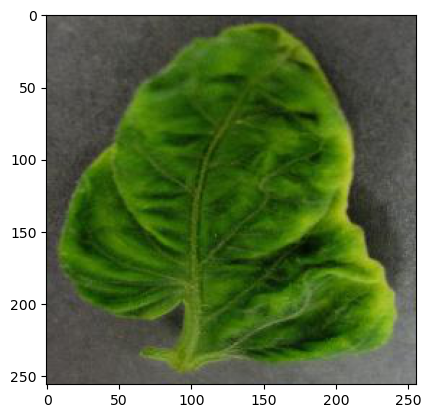

In [8]:
import random
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
df=pd.read_csv('../input/train.csv')
sample = random.choice(df.Image)
image = load_img("../input/train/train/"+sample)
plt.imshow(image)

In [9]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout

model = models.Sequential()

model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (128, 128, 3)))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))

model.add(Flatten())
model.add(Dense(500, activation="relu", name='rl'))
model.add(Dropout(0.8))
model.add(Dense(10, activation='softmax', name='sm'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 122, 122, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 122, 122, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 122, 122, 32)      0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 61, 61, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 59, 59, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 59, 59, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 19, 19, 64)        0

In [10]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [11]:
epochs= 20 # set to what you want
history=model.fit(x=train_gen, epochs=epochs,steps_per_epoch=train_steps,   
            validation_data=valid_gen, validation_steps=valid_steps,
            shuffle=False,  verbose=1)

Epoch 1/20
317/317 [==============================] - 48s 115ms/step - loss: 1.6777 - accuracy: 0.4999 - val_loss: 1.5939 - val_accuracy: 0.4807
Epoch 2/20
317/317 [==============================] - 34s 107ms/step - loss: 1.0052 - accuracy: 0.6659 - val_loss: 1.4666 - val_accuracy: 0.5476
Epoch 3/20
317/317 [==============================] - 34s 107ms/step - loss: 0.8152 - accuracy: 0.7290 - val_loss: 1.2134 - val_accuracy: 0.6404
Epoch 4/20
317/317 [==============================] - 34s 107ms/step - loss: 0.7078 - accuracy: 0.7638 - val_loss: 0.6390 - val_accuracy: 0.7750
Epoch 5/20
317/317 [==============================] - 34s 107ms/step - loss: 0.6469 - accuracy: 0.7834 - val_loss: 4.5060 - val_accuracy: 0.3289
Epoch 6/20
317/317 [==============================] - 34s 107ms/step - loss: 0.5830 - accuracy: 0.8069 - val_loss: 0.7417 - val_accuracy: 0.7616
Epoch 7/20
317/317 [==============================] - 34s 107ms/step - loss: 0.5032 - accuracy: 0.8301 - val_loss: 1.4082 - val_ac

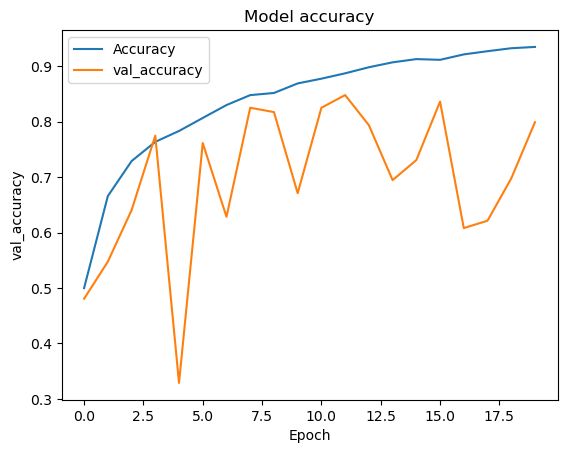

In [12]:


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.ylabel('val_accuracy')

plt.legend (['Accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.show()

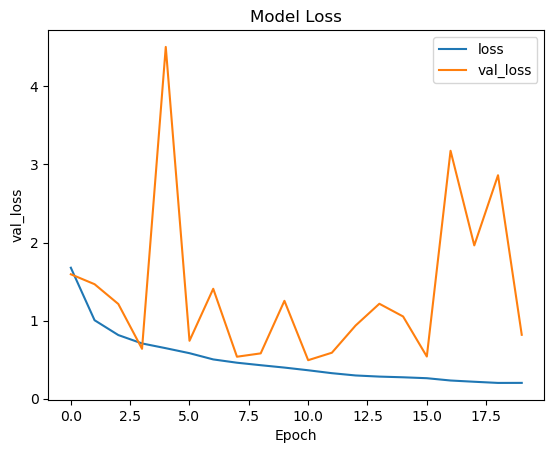

In [13]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('loss')
plt.ylabel('val_loss')

plt.legend (['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.show()

In [14]:
accuracy=model.evaluate(test_gen, steps=test_steps)[1]*100
print ('Model accuracy on test set is', accuracy)

41/41 [==============================] - 4s 107ms/step - loss: 0.8473 - accuracy: 0.7797
Model accuracy on test set is 77.97009944915771


In [15]:
predictions=model.predict(test_gen, steps=test_steps, verbose=1)

41/41 [==============================] - 4s 78ms/step
